In [15]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

Populating the interactive namespace from numpy and matplotlib


C:\Users\Admin\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['partition', 'pad', 'array', '__version__', 'random', 'subplots', 'f', 'copy', 'uniform']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [16]:
path=Path('data')

In [17]:
path.ls()

[WindowsPath('data/Anno'),
 WindowsPath('data/Eval'),
 WindowsPath('data/img'),
 WindowsPath('data/input_img.jpg'),
 WindowsPath('data/README.txt')]

In [18]:
f=open(path/"Anno/list_category_cloth.txt", "r")
contents =f.read().splitlines()
print(contents)


['50', 'category_name  category_type', 'Anorak         1', 'Blazer         1', 'Blouse         1', 'Bomber         1', 'Button-Down    1', 'Cardigan       1', 'Flannel        1', 'Halter         1', 'Henley         1', 'Hoodie         1', 'Jacket         1', 'Jersey         1', 'Parka          1', 'Peacoat        1', 'Poncho         1', 'Sweater        1', 'Tank           1', 'Tee            1', 'Top            1', 'Turtleneck     1', 'Capris         2', 'Chinos         2', 'Culottes       2', 'Cutoffs        2', 'Gauchos        2', 'Jeans          2', 'Jeggings       2', 'Jodhpurs       2', 'Joggers        2', 'Leggings       2', 'Sarong         2', 'Shorts         2', 'Skirt          2', 'Sweatpants     2', 'Sweatshorts    2', 'Trunks         2', 'Caftan         3', 'Cape           3', 'Coat           3', 'Coverup        3', 'Dress          3', 'Jumpsuit       3', 'Kaftan         3', 'Kimono         3', 'Nightdress     3', 'Onesie         3', 'Robe           3', 'Romper         3', '

In [19]:
num_classes = int(contents[0])
print(num_classes)

50


In [20]:
classes = []
for i in range(2,len(contents)):
    classes.append(contents[i].split(" ")[0])
print(classes)

['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Flannel', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jersey', 'Parka', 'Peacoat', 'Poncho', 'Sweater', 'Tank', 'Tee', 'Top', 'Turtleneck', 'Capris', 'Chinos', 'Culottes', 'Cutoffs', 'Gauchos', 'Jeans', 'Jeggings', 'Jodhpurs', 'Joggers', 'Leggings', 'Sarong', 'Shorts', 'Skirt', 'Sweatpants', 'Sweatshorts', 'Trunks', 'Caftan', 'Cape', 'Coat', 'Coverup', 'Dress', 'Jumpsuit', 'Kaftan', 'Kimono', 'Nightdress', 'Onesie', 'Robe', 'Romper', 'Shirtdress', 'Sundress']


In [21]:
f=open(path/"Anno/list_category_img.txt", "r")
labels_content =f.read().splitlines()

In [22]:
labels = []
for i in range(2,len(labels_content)):
    labels.append(labels_content[i].split())
print(labels[0:2])

[['img/Sheer_Pleated-Front_Blouse/img_00000001.jpg', '3'], ['img/Sheer_Pleated-Front_Blouse/img_00000002.jpg', '3']]


In [23]:
labels_df = pd.DataFrame(labels)
labels_df.rename(columns = {0:'filename',1:'label'}, inplace = True) 
labels_df.head()

,filename,label
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3


In [31]:
trained_labels = labels_df.sample(n=60000, random_state=1)

In [32]:
data=ImageDataBunch.from_df(path=path/"", df=trained_labels, valid_pct=0.2, fn_col='filename', label_col='label', 
                            ds_tfms=get_transforms(), size=256, bs=64).normalize(imagenet_stats)

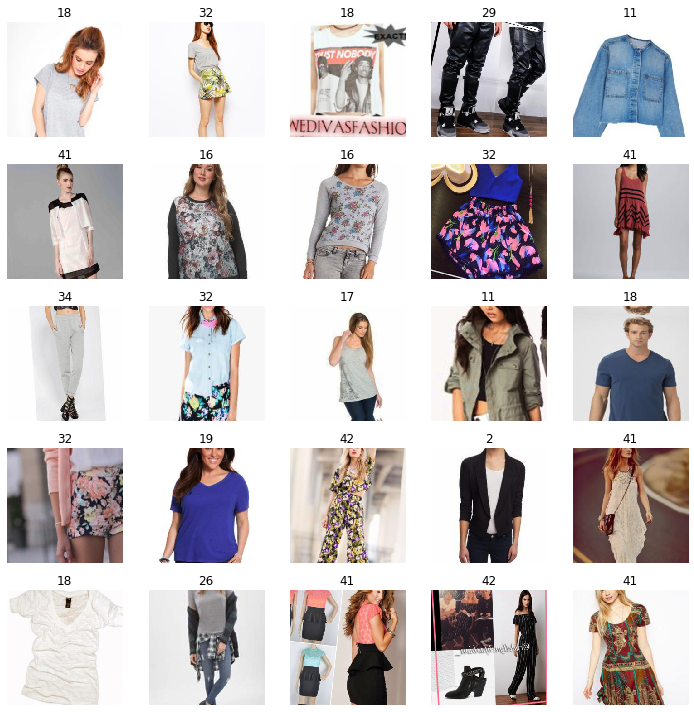

In [33]:
data.show_batch(figsize=(10,10))

In [34]:
learn=cnn_learner(data, models.resnet34, metrics=accuracy)

In [35]:
learn.freeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.recorder.plot()

In [ ]:
lr=5e-2
learn.fit_one_cycle(4, slice(lr/10, lr))

In [ ]:
interp=ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(k=6, figsize=(12, 8))

In [ ]:
learn.save("trained_model_2")

## Showing results

In [ ]:
with torch.no_grad():
    x,y = next(iter(learn.data.valid_dl))
    yhat = learn.model(x.to('cuda'))

In [ ]:
x.shape, y[0].shape, yhat.shape